In [3]:
%matplotlib widget
# Implementation of vectorial-BPM as derived in Himanshu's notes.
# Support both 1D and 2D simulations, and the optional consideration of polarization effects.
import numpy as np
import matplotlib.pyplot as plt

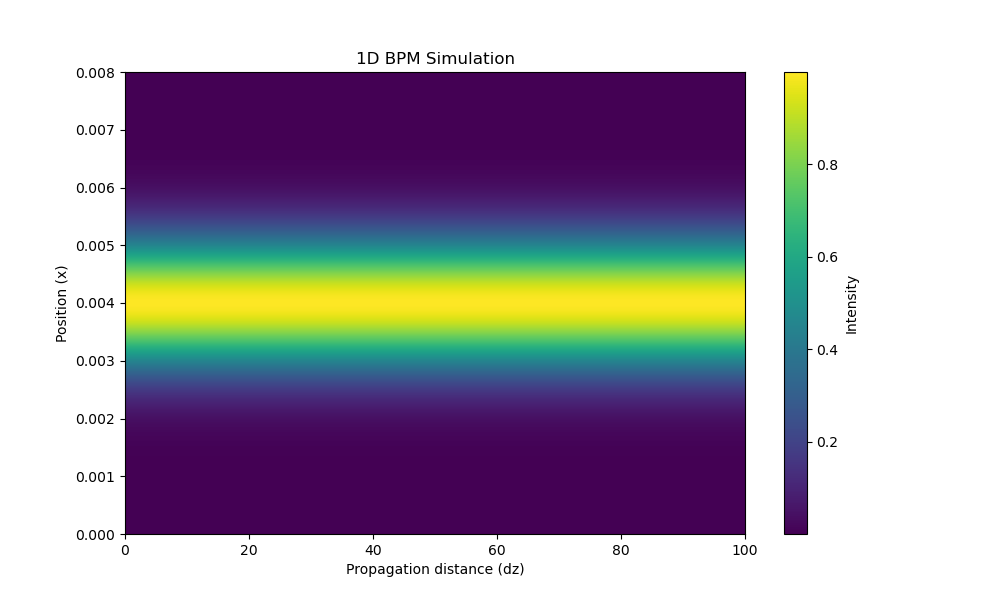

In [120]:
# Basic 1D non-polarized implementation
def bpm_1d(u, n, dx, dz, steps, plot=False, interactive=False):
    if plot:
        steps_data = np.zeros((u.shape[0], steps), dtype=complex)

    #u_(z+dz) = F^-1 { F{u_z} * exp(-1j/2*k_x*dz) } * exp(1j*dz/2) * exp(-1j/2*n^2*k0*dz)
    k0 = 2 * np.pi / 0.3e-9  # Wavelength in vacuum (in m)
    kx = np.fft.fftfreq(len(u), d=dx) * 2 * np.pi
    #kx = np.fft.fftshift(kx)  # Shift zero frequency to center
    #u = np.fft.fftshift(u)  # Shift zero frequency to center
    for i in range(steps):
        # Propagate in the spatial frequency domain
        u_freq = np.fft.fft(u)
        u_freq *= np.exp(-1j * kx**2 * dz / (2 * k0))  # Apply the propagation phase factor
        u = np.fft.ifft(u_freq)  # Inverse FFT to get back to spatial domain
        
        # Apply the linear phase factor
        u *= np.exp(1j * dz / 2)
        # Apply the quadratic phase factor
        u *= np.exp(-1j * n**2 * k0 * dz / 2)

        if plot:
            steps_data[:, i] = u
    if plot:
        if not interactive:
            plt.figure(figsize=(10, 6))
            plt.imshow(np.abs(steps_data), aspect='auto', extent=(0, steps * dz, 0, len(u) * dx))
            plt.title('1D BPM Simulation')
            plt.xlabel('Propagation distance (dz)')
            plt.ylabel('Position (x)')
            plt.colorbar(label='Intensity')
            plt.show()
        else:
            # Add an interactive slider for propagation distance
            from ipywidgets import interact, FloatSlider
            def update(step):
                plt.clf()
                plt.figure(figsize=(10, 6))
                plt.plot(np.abs(steps_data[:, int(step/dz)]))
                plt.title(f'1D BPM Simulation at step {step}')
                plt.xlabel('Position (x)')
                plt.ylabel('Intensity')
                #plt.xlim(0, len(u) * dx)
                #plt.ylim(0, np.max(np.abs(steps_data)))
                plt.grid()
                plt.show()
            interact(update, step=FloatSlider(min=0, max=(steps-1)*dz, step=dz, value=0, description='Step'))

    return u

dx = 8e-3 / 500
nx = 500

sigma = dx * 50  # Standard deviation for Gaussian pulse
x = np.linspace(-nx * dx / 2, nx * dx / 2, nx)
_1d_gaussian = np.exp(-(x**2) / (2 * sigma**2))
# Example usage of the 1D BPM function
result_1d = bpm_1d(_1d_gaussian, n=1, dx=dx, dz=1, steps=100, plot=True, interactive=not True)



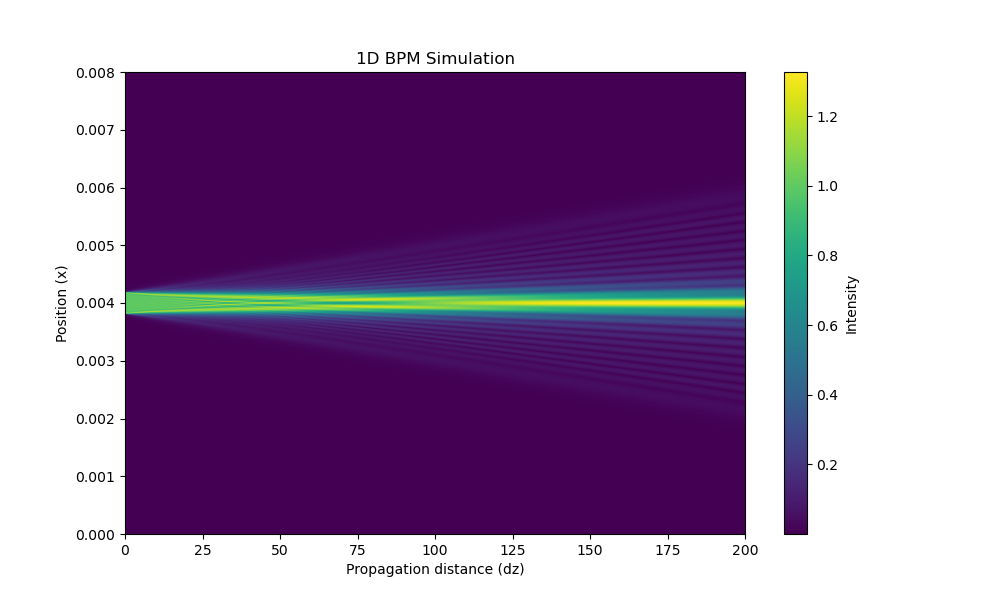

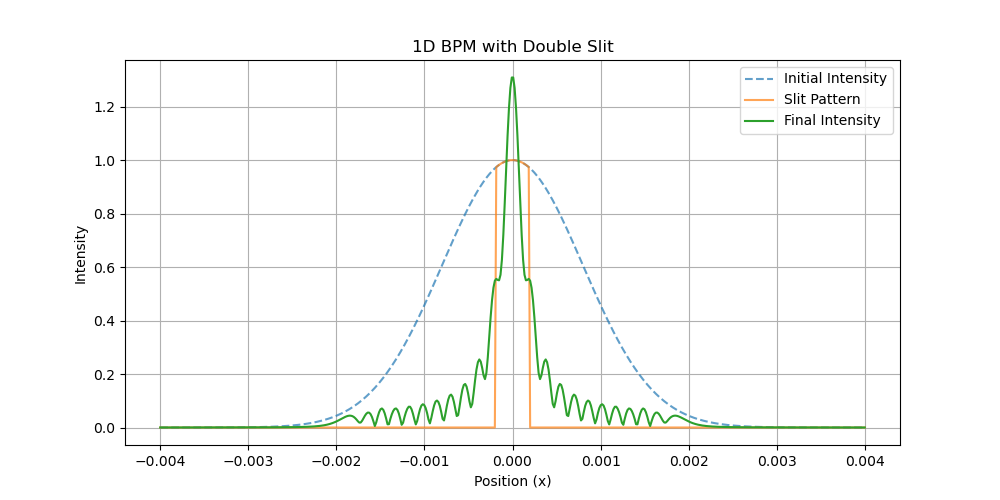

In [130]:
# 1D bpm with single slit diffraction pattern
lspace = np.linspace(-nx * dx / 2, nx * dx / 2, nx)
_1d_gaussian = np.exp(-(lspace**2) / (2 * sigma**2))

single_slit = np.zeros_like(_1d_gaussian)
single_slit[np.abs(lspace) < 0.2e-3] = 1  # Single slit diffraction
double_slit = np.zeros_like(_1d_gaussian)
double_slit[np.abs(lspace) < 0.6e-3] = 1  # Double slit diffraction
double_slit[np.abs(lspace) < 0.3e-3] = 0
slit = single_slit
result_1d = bpm_1d(_1d_gaussian * slit, n=1.0, dx=dx, dz=0.2, steps=1000, plot=True, interactive=False)

# Plot the initial and final result
plt.figure(figsize=(10, 5))
plt.plot(lspace, np.abs(_1d_gaussian), label='Initial Intensity', linestyle='--', alpha=0.7)
plt.plot(lspace, np.abs(slit * _1d_gaussian), label='Slit Pattern', alpha=0.7)
plt.plot(lspace, np.abs(result_1d), label='Final Intensity')
plt.title('1D BPM with Double Slit')
plt.xlabel('Position (x)')
plt.ylabel('Intensity')
#plt.xlim(-0.5, 0.5)
plt.legend()
plt.grid()
plt.show()

(1000, 1000)
Step 0/100 completed.


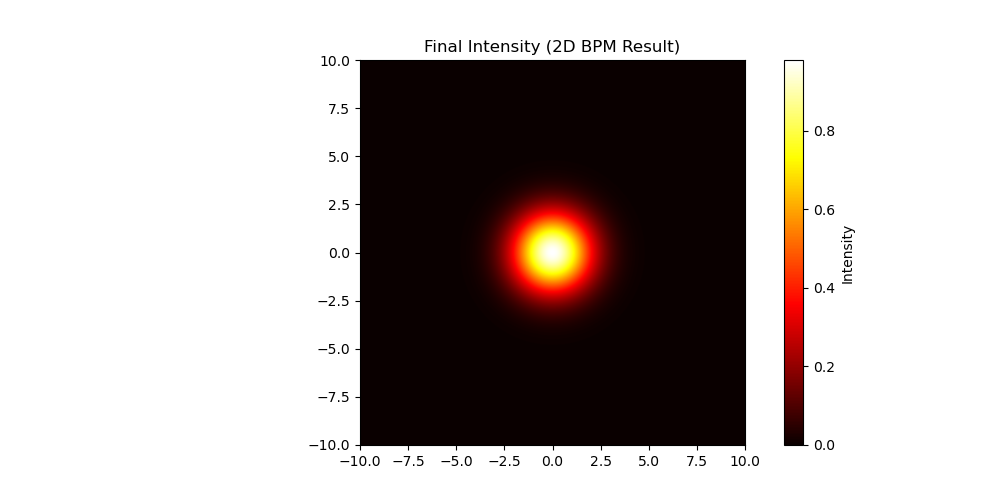

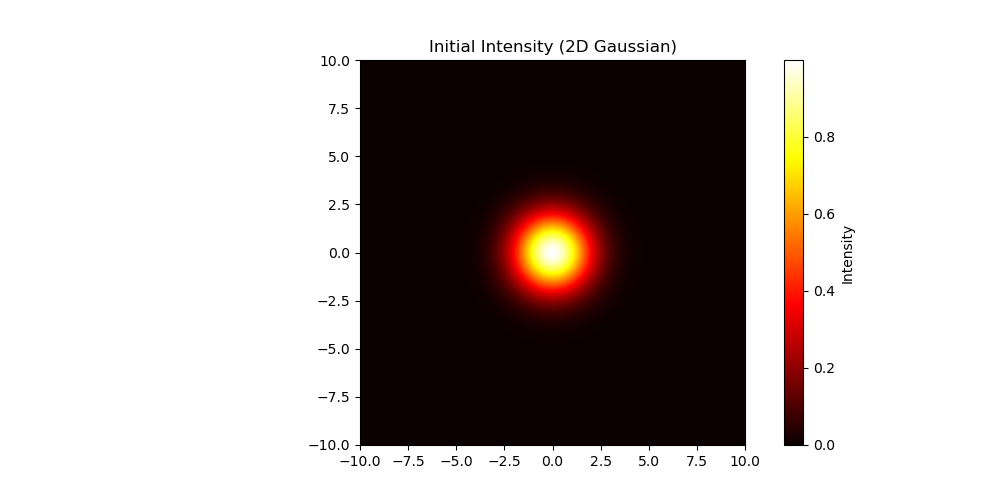

In [49]:
# 2D non-polarized implementation
def bpm_2d(u, n, dx, dy, dz, steps):

    #u_(z+dz) = F^-1 { F{u_z} * exp(-1j/2*K*dz) } * exp(1j*dz/2) * exp(-1j/2*n^2*k0^2*dz) * exp(2j * W_0 * dz)
    # where K = [k_y, k_x]*[k_y, k_x]^T
    # where W_0 = [[W_xx, W_xy], [W_yx, W_yy]]
    # W_xx = ((n[i+1, j] - 2*n[i, j] + n[i-1, j]) / dx^2)
    # W_yy = ((n[i, j+1] - 2*n[i, j] + n[i, j-1]) / dy^2)
    # W_xy = W_yx = ((n[i+1, j+1] - n[i+1, j-1] - n[i-1, j+1] + n[i-1, j-1]) / (4*dx*dy))

    #If n is a scalar, W will be 0
    if np.isscalar(n):
        W = np.zeros((2, 2))
        W_xx = W_yy = W_xy = W_yx = 0
    else:
        W_xx = np.zeros_like(n)
        W_yy = np.zeros_like(n)
        W_xy = np.zeros_like(n)
        W_yx = np.zeros_like(n)
        W_xx[1:-1, 1:-1] = (n[2:, 1:-1] - 2*n[1:-1, 1:-1] + n[:-2, 1:-1]) / dx**2
        W_yy[1:-1, 1:-1] = (n[1:-1, 2:] - 2*n[1:-1, 1:-1] + n[1:-1, :-2]) / dy**2
        W_xy[1:-1, 1:-1] = (n[2:, 2:] - n[2:, :-2] - n[:-2, 2:] + n[:-2, :-2]) / (4 * dx * dy)
        W_yx[1:-1, 1:-1] = W_xy[1:-1, 1:-1]  # Symmetric
        W = np.array([[W_xx, W_xy], [W_yx, W_yy]])
    k0 = 2 * np.pi / 1.55  # Wavelength in vacuum (in microns)
    kx = np.fft.fftfreq(u.shape[1], d=dx) * 2 * np.pi
    ky = np.fft.fftfreq(u.shape[0], d=dy) * 2 * np.pi
    kx, ky = np.meshgrid(kx, ky)  # Create a meshgrid for kx and ky
    k = (kx**2 + ky**2)  # Calculate the magnitude of the wavevector

    print (k.shape)

    for i in range(steps):
        # Propagate in the spatial frequency domain
        u_freq = np.fft.fft2(u)
        u_freq *= np.exp(-1j * k * dz / 2)
        u = np.fft.ifft2(u_freq)
        # Apply the linear phase factor
        u *= np.exp(1j * dz / 2)
        # Apply the quadratic phase factor
        u *= np.exp(-1j * n**2 * k0**2 * dz / 2)
        # Apply the W matrix phase factor
        u *= np.exp(2j * (W_xx + W_yy) * dz / 2)
        if i % 100 == 0:
            print(f'Step {i}/{steps} completed.')
    return u

# Example usage of the 2D BPM function
lspace_x = np.linspace(-5, 5, 1000)
lspace_y = np.linspace(-5, 5, 1000)
_2d_gaussian = np.exp(-np.meshgrid(lspace_x, lspace_y)[0]**2 - np.meshgrid(lspace_x, lspace_y)[1]**2)
result_2d = bpm_2d(_2d_gaussian, n=1.0, dx=0.1, dy=0.1, dz=0.1, steps=100)
# Plot the initial and final result for 2D BPM
plt.figure(figsize=(10, 5))
plt.imshow(np.abs(_2d_gaussian), extent=(-10, 10, -10, 10), origin='lower', cmap='hot')
plt.title('Initial Intensity (2D Gaussian)')
plt.colorbar(label='Intensity')
plt.figure(figsize=(10, 5))
plt.imshow(np.abs(result_2d), extent=(-10, 10, -10, 10), origin='lower', cmap='hot')
plt.title('Final Intensity (2D BPM Result)')
plt.colorbar(label='Intensity')
plt.show()

(1000, 1000)
Step 0/500 completed.
Step 100/500 completed.
Step 200/500 completed.
Step 300/500 completed.
Step 400/500 completed.


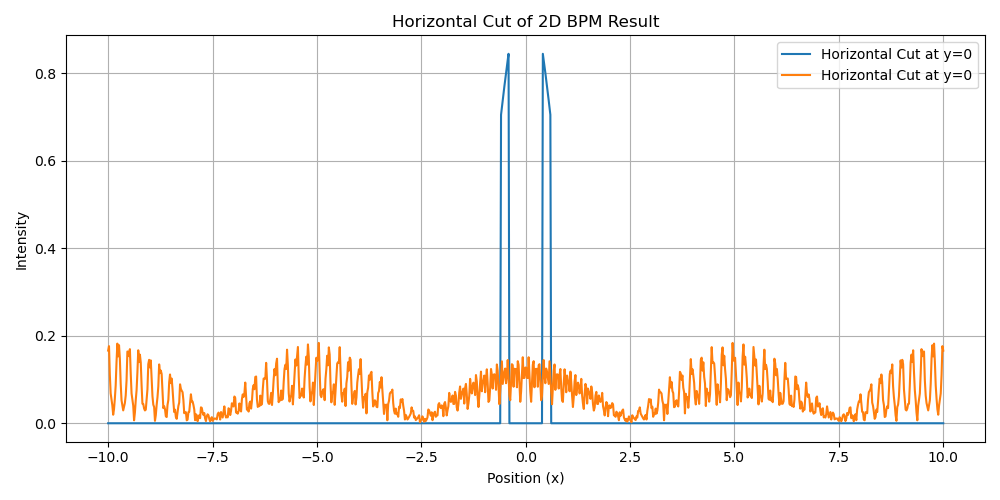

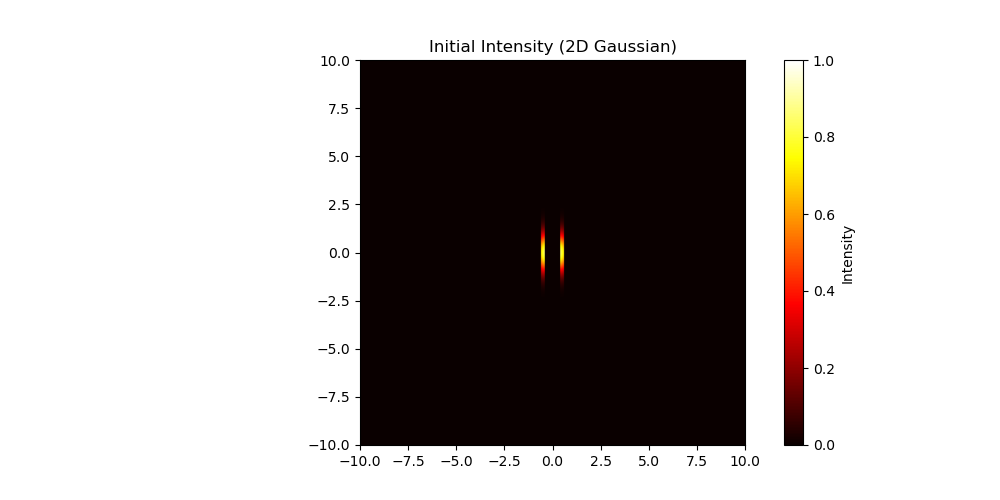

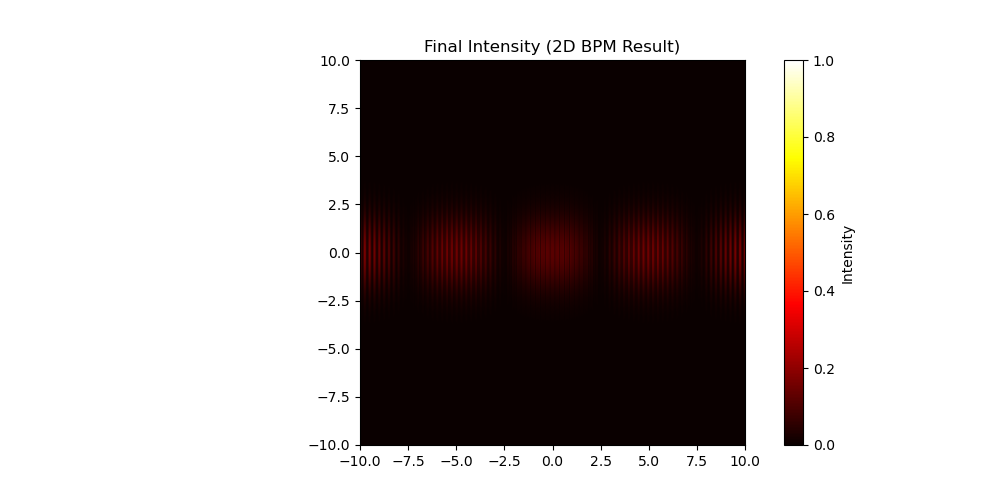

In [51]:
# Example usage of the 2D BPM function with slits
lspace_x = np.linspace(-10, 10, 1000)
lspace_y = np.linspace(-10, 10, 1000)
_2d_gaussian = np.exp(-np.meshgrid(lspace_x, lspace_y)[0]**2 - np.meshgrid(lspace_x, lspace_y)[1]**2)

single_slit = np.zeros_like(_2d_gaussian)
single_slit[np.abs(np.meshgrid(lspace_x, lspace_y)[0]) < 0.6] = 1  # Single slit diffraction
double_slit = np.zeros_like(_2d_gaussian)
double_slit[np.abs(np.meshgrid(lspace_x, lspace_y)[0]) < 0.6] = 1  # Double slit diffraction
double_slit[np.abs(np.meshgrid(lspace_x, lspace_y)[0]) < 0.4] = 0
slit = double_slit

result_2d = bpm_2d(_2d_gaussian*slit, n=1.0, dx=0.1, dy=0.1, dz=0.04, steps=500)
# Plot the initial and final result for 2D BPM
plt.figure(figsize=(10, 5))
plt.imshow(np.abs(_2d_gaussian*slit), extent=(-10, 10, -10, 10), origin='lower', cmap='hot', vmax=1, vmin=0)
plt.title('Initial Intensity (2D Gaussian)')
plt.colorbar(label='Intensity')
plt.figure(figsize=(10, 5))
plt.imshow(np.abs(result_2d), extent=(-10, 10, -10, 10), origin='lower', cmap='hot', vmax=1, vmin=0)
plt.title('Final Intensity (2D BPM Result)')
plt.colorbar(label='Intensity')
#Show horizontal cuts
plt.figure(figsize=(10, 5))
plt.plot(lspace_x, np.abs(_2d_gaussian*slit)[500, :], label='Horizontal Cut at y=0')
plt.plot(lspace_x, np.abs(result_2d[500, :]), label='Horizontal Cut at y=0')
plt.title('Horizontal Cuts')
plt.xlabel('Position (x)')
plt.ylabel('Intensity')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
